In [1]:
import random
import keras
import subprocess
import pickle
import keras_metrics as km
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Embedding, Dropout, LSTM, Activation, Conv1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import Callback

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = Tokenizer()

Using TensorFlow backend.


In [2]:
def get_data(bot_file, gen_file):
    x_data = []
    with open(bot_file, 'r', errors='ignore') as file:
        for line in file:
            x_data.append(line)

    size = len(x_data)

    with open(gen_file, 'r', errors='ignore') as file:
        for line in file:
            x_data.append(line)

    y_data = [1] * size + [0] * size

    train_set = list(zip(x_data, y_data))
    random.shuffle(train_set)
    x, y = zip(*train_set)
    return np.array(x), np.array(y)

In [3]:
x, y = get_data('trv-bot.txt', 'trv-gen.txt')

In [4]:
x_test, y_test = get_data('test-bot.txt', 'test-gen.txt')

In [5]:
vec = TfidfVectorizer(max_features=100,
                      tokenizer=word_tokenize,
                      strip_accents='unicode',
                      lowercase =True,
                      analyzer='word',
                      token_pattern=r'\w+',
                      use_idf=True,
                      smooth_idf=True,
                      sublinear_tf=False, 
                      stop_words = 'english'
                     )
tfidf_mat = vec.fit_transform(x).toarray()
print(type(tfidf_mat),tfidf_mat.shape)

<class 'numpy.ndarray'> (639996, 100)


In [6]:
test_tfidf_mat = vec.transform(x_test).toarray()
print(type(test_tfidf_mat),test_tfidf_mat.shape)

<class 'numpy.ndarray'> (159996, 100)


In [17]:
model = Sequential()
model.add(Dense(512,input_shape=(100,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy',km.binary_precision(), km.binary_recall()]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               51712     
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
__________

In [18]:
history = model.fit(
    tfidf_mat,
    y,
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_split=0.25
)

Train on 479997 samples, validate on 159999 samples
Epoch 1/20
479997/479997 [==============================] - 10s 20us/step - loss: 0.3235 - acc: 0.8514 - precision: 0.8933 - recall: 0.7982 - val_loss: 0.3008 - val_acc: 0.8612 - val_precision: 0.9055 - val_recall: 0.8066
Epoch 2/20
479997/479997 [==============================] - 9s 18us/step - loss: 0.3021 - acc: 0.8623 - precision: 0.9038 - recall: 0.8110 - val_loss: 0.2981 - val_acc: 0.8639 - val_precision: 0.9128 - val_recall: 0.8047
Epoch 3/20
479997/479997 [==============================] - 9s 18us/step - loss: 0.2954 - acc: 0.8659 - precision: 0.9107 - recall: 0.8113 - val_loss: 0.2917 - val_acc: 0.8662 - val_precision: 0.9063 - val_recall: 0.8169
Epoch 4/20
479997/479997 [==============================] - 9s 18us/step - loss: 0.2909 - acc: 0.8681 - precision: 0.9133 - recall: 0.8134 - val_loss: 0.2895 - val_acc: 0.8685 - val_precision: 0.9096 - val_recall: 0.8184
Epoch 5/20
479997/479997 [==============================] - 9s 

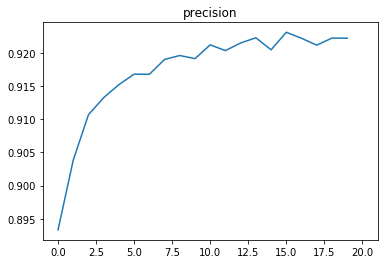

In [19]:
plt.xlim(left=-1, right=21)
plt.title('precision')
plt.plot(history.history['precision'], label='train')
plt.savefig('tfidf-c/precision.svg')

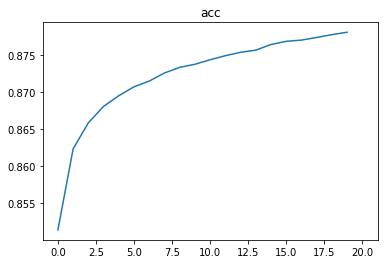

In [20]:
plt.xlim(left=-1, right=21)
plt.title('acc')
plt.plot(history.history['acc'], label='train')
plt.savefig('tfidf-c/accuracy.svg')

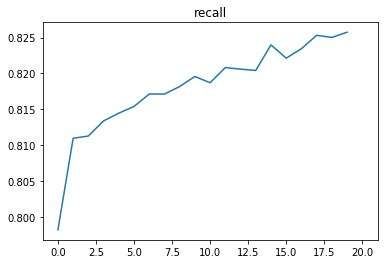

In [21]:
plt.xlim(left=-1, right=21)
plt.title('recall')
plt.plot(history.history['recall'], label='train')
plt.savefig('tfidf-c/recall.svg')

In [22]:
y_pred = model.predict(test_tfidf_mat).ravel()
fpr, tpr, threshold = roc_curve(y_test, y_pred)

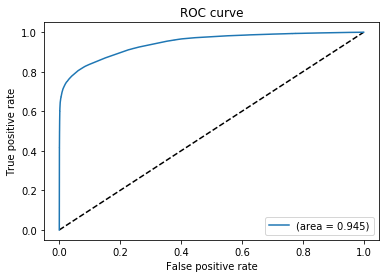

In [23]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='(area = {:.3f})'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('tfidf-c/roc.svg')

In [24]:
score, acc, p, r = model.evaluate(test_tfidf_mat, y_test)
print('score:', score)
print('accuracy:', acc)
print('precision:', p)
print('recall:', r)

159996/159996 [==============================] - 3s 20us/step
score: 0.2864272940241995
accuracy: 0.8718905472621914
precision: 0.9247583558188421
recall: 0.809657741442524


In [25]:
model.save_weights("tfidf-c/model.h5")
print("Saved model to disk")

Saved model to disk
